In [44]:
import warnings
warnings.filterwarnings(action='ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import keras
import pydot
import graphviz
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
import glob
%matplotlib inline


In [46]:
tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11935408249201525703]

In [47]:
dataset_paths = glob.glob("placas/**/**/*.jpg")

In [48]:
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

[INFO] Find 226 images with 3 classes


In [50]:

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


traindata = image_generator.flow_from_directory("placas/Train/",
                                           target_size = (300, 300),
                                           class_mode = 'categorical',
                                           batch_size = 500)
testdata = image_generator.flow_from_directory('placas/Test/',
                                           target_size = (300, 300),
                                           class_mode = 'categorical',
                                           batch_size = 75)
valdata = image_generator.flow_from_directory('placas/Validation/',
                                           target_size = (300, 300),
                                           class_mode = 'categorical',
                                           batch_size = 75)

Found 156 images belonging to 3 classes.
Found 46 images belonging to 3 classes.
Found 48 images belonging to 3 classes.


226
[176 224 139 109  33 222 132  70  70  22 133   2]


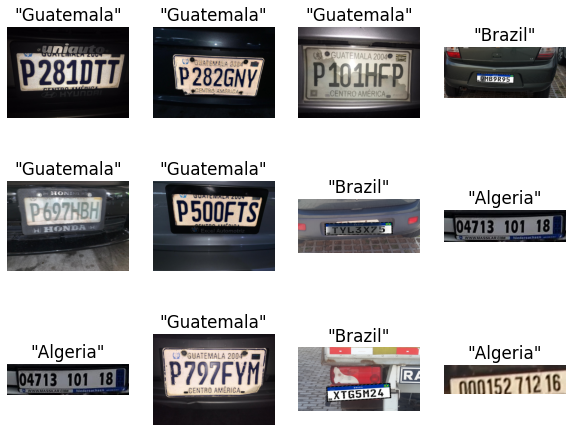

In [53]:
cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(50)
print(len(dataset_paths))
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))
print(rand)
# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

In [55]:
# Ahora creamos la Red Neuronal, con 3 layers (incluyendo un drop después de cada uno para evitar el overfitting) #
# y definimos el Dropout con 20% para que se eliminen algunas conecciones entre las capas #

## Primera Capa ##
modelo = Sequential()
modelo.add(Conv2D(16, (3, 3), activation = 'relu', input_shape = (300, 300, 3)))
modelo.add(MaxPooling2D(pool_size=(2,2)))
## Segunda Capa ##
modelo.add(Conv2D(8, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
## Segunda Capa ##
modelo.add(Conv2D(4, (3, 3), activation = 'relu'))
modelo.add(MaxPooling2D(pool_size = (2,2)))
modelo.add(Dropout(0.20))
## Dense ##
modelo.add(Flatten())
modelo.add(Dense(2, activation = 'softmax'))

## Finalmente compilamos el modelo entero ##
modelo.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(modelo.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 8)       1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 4)         292       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 4)        

In [64]:
from tensorflow.keras.utils import plot_model
plot_model(modelo, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
